In [1]:
from flu_matrix_completion import *

In [2]:
'''
Prepare a source for predictions:
- Identify a 2 datasets with good transferability
- Choose source dataset
- Train and cross validate a tree for every virus in source dataset, choosing 5 best trees per virus
    - Feats and target both come from source
    - Select viable virus features from viruses which overlap both datasets!
- Now with a tree for every virus in Dataset 1
    - Pull required feature viruses from Dataset 2 and make a prediction with the tree
- Put the prediction thing above into a loop to see how well Dataset2 can be reconstructed
'''

'''
Predictions:

1.) Train comparison on datasets
2.) Go to OBJ.comparison_dict  holds trees trained on source data that target other dataset's viruses
3.) Go to OBJ.comparison_dict[COMPARISON] to access each target virus
4.) Go to OBJ.comparison_dict[COMPARISON][VIRUS] to access each target virus's:
    - regression model (IMPORTANT)
    - intraRMSE
    - crossRMSE
    - feature viruses (IMPORTANT)
    - predictions
'''
def predict_target(m_best_trees_trainer_lists, target_dataset):
    '''
    Assuming target_dataset contains data for each virus in virus_col_sel
    
    dtr: model
    virus_col_sel: features to use for prediction
    feature_t: virus to be predicted in target_dataset
    '''
    predictions_to_be_meaned = []
    for l in m_best_trees_trainer_lists:
        dtr, _, _, virus_col_sel, feature_t, _, _ = l
        X = target_dataset[virus_col_sel]
        col_mean = (X).apply(lambda x: x.mean(), axis=1)
        centering_matrix =  np.outer(np.ones(X.shape[1]), col_mean).T
        X_m_centered = X - centering_matrix # Center data
        preds = dtr.predict(X_m_centered.to_numpy())
        predictions_to_be_meaned.append(preds + col_mean) # Uncenter prediction
    predictions_to_be_meaned = np.array(predictions_to_be_meaned)
    return np.mean(predictions_to_be_meaned, axis=0) # Returns a list of prediction corresponding to each antibody sera in target_dataset

def train_cross_dataset_model(source_table, target_table, n_feature = 7, f_sample=0.3, train_trees=50, best_trees=10):
    '''
    Returns a dict where "viable" viruses are keys and m_best_trees_trainer_lists are values
    '''
    source_table_feature_set = set(source_table.columns)
    target_table_feature_set = set(target_table.columns)
    intersection = list(source_table_feature_set.intersection(target_table_feature_set)) # Train trees on random samples from intersection
    
    m_best_trees_trainer_lists_per_target_virus = dict()
    for feature_t in list(source_table_feature_set):
        selected_viruses_list = np.random.choice(intersection, n_feature) # Might need to tweak this step to consider depth of data...
#         print(type(selected_viruses_list), selected_viruses_list)
        source_table_trees = m_best_trees_trainer(target_table = source_table,
                                                  source_tables = [source_table],
                                                  feature_t = feature_t,
                                                  selected_viruses_list= selected_viruses_list,
                                                  n_feature = n_feature,
                                                  f_sample=f_sample,
                                                  train_trees=train_trees,
                                                  best_trees=best_trees)
        m_best_trees_trainer_lists_per_target_virus[feature_t] = source_table_trees
    return m_best_trees_trainer_lists_per_target_virus, intersection # intersection will tell you which virus to assign to your predictions

def compute_predicted_df(m_best_trees_trainer_lists_per_target_virus, intersection, target_dataset):
    
    df = pd.DataFrame(np.nan, index=target_dataset.index, columns=target_dataset.columns)
    
    for key in m_best_trees_trainer_lists_per_target_virus:
#         for sera in target_dataset.index:
#             print()
        m_best_trees_trainer_lists = m_best_trees_trainer_lists_per_target_virus[key]
        df.loc[:, key] = predict_target(m_best_trees_trainer_lists, target_dataset)
        
    return df.dropna(axis=0, how='all')


In [3]:
# Load in antisera-virus data as pd.DataFrames
HI_df = pd.read_csv("data/fonville_2014.csv", index_col='sampleID')
antisera_df = pd.read_csv("data/fonville_2014_antisera_table.csv", index_col='sampleID')
## Add data to HI_data_tables object
flu_data_tables = HI_data_tables() # Create HI_data_tables object
flu_data_tables.add_HI_data(HI_df=HI_df,
                            antisera_df=antisera_df) # Add data from Tal's ad Rong's original paper
flu_data_tables.compute_virus_dates() # Call compute_virus_dates method to compute years of virus

# Load in antisera-virus data as pd.DataFrames
all_HI_df = pd.read_csv("data/fonville_hinojosa_ertesvag_data.csv", index_col='sampleID')
all_antisera_df = pd.read_csv("data/fonville_merged_hinojosa_antisera_table.csv", index_col='sampleID')
all_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
all_HI_data_tables.add_HI_data(HI_df=all_HI_df,
                               antisera_df=all_antisera_df) # Add data from Tal's ad Rong's original paper
all_HI_data_tables.compute_virus_dates()

## Load Fonville 2014 Data

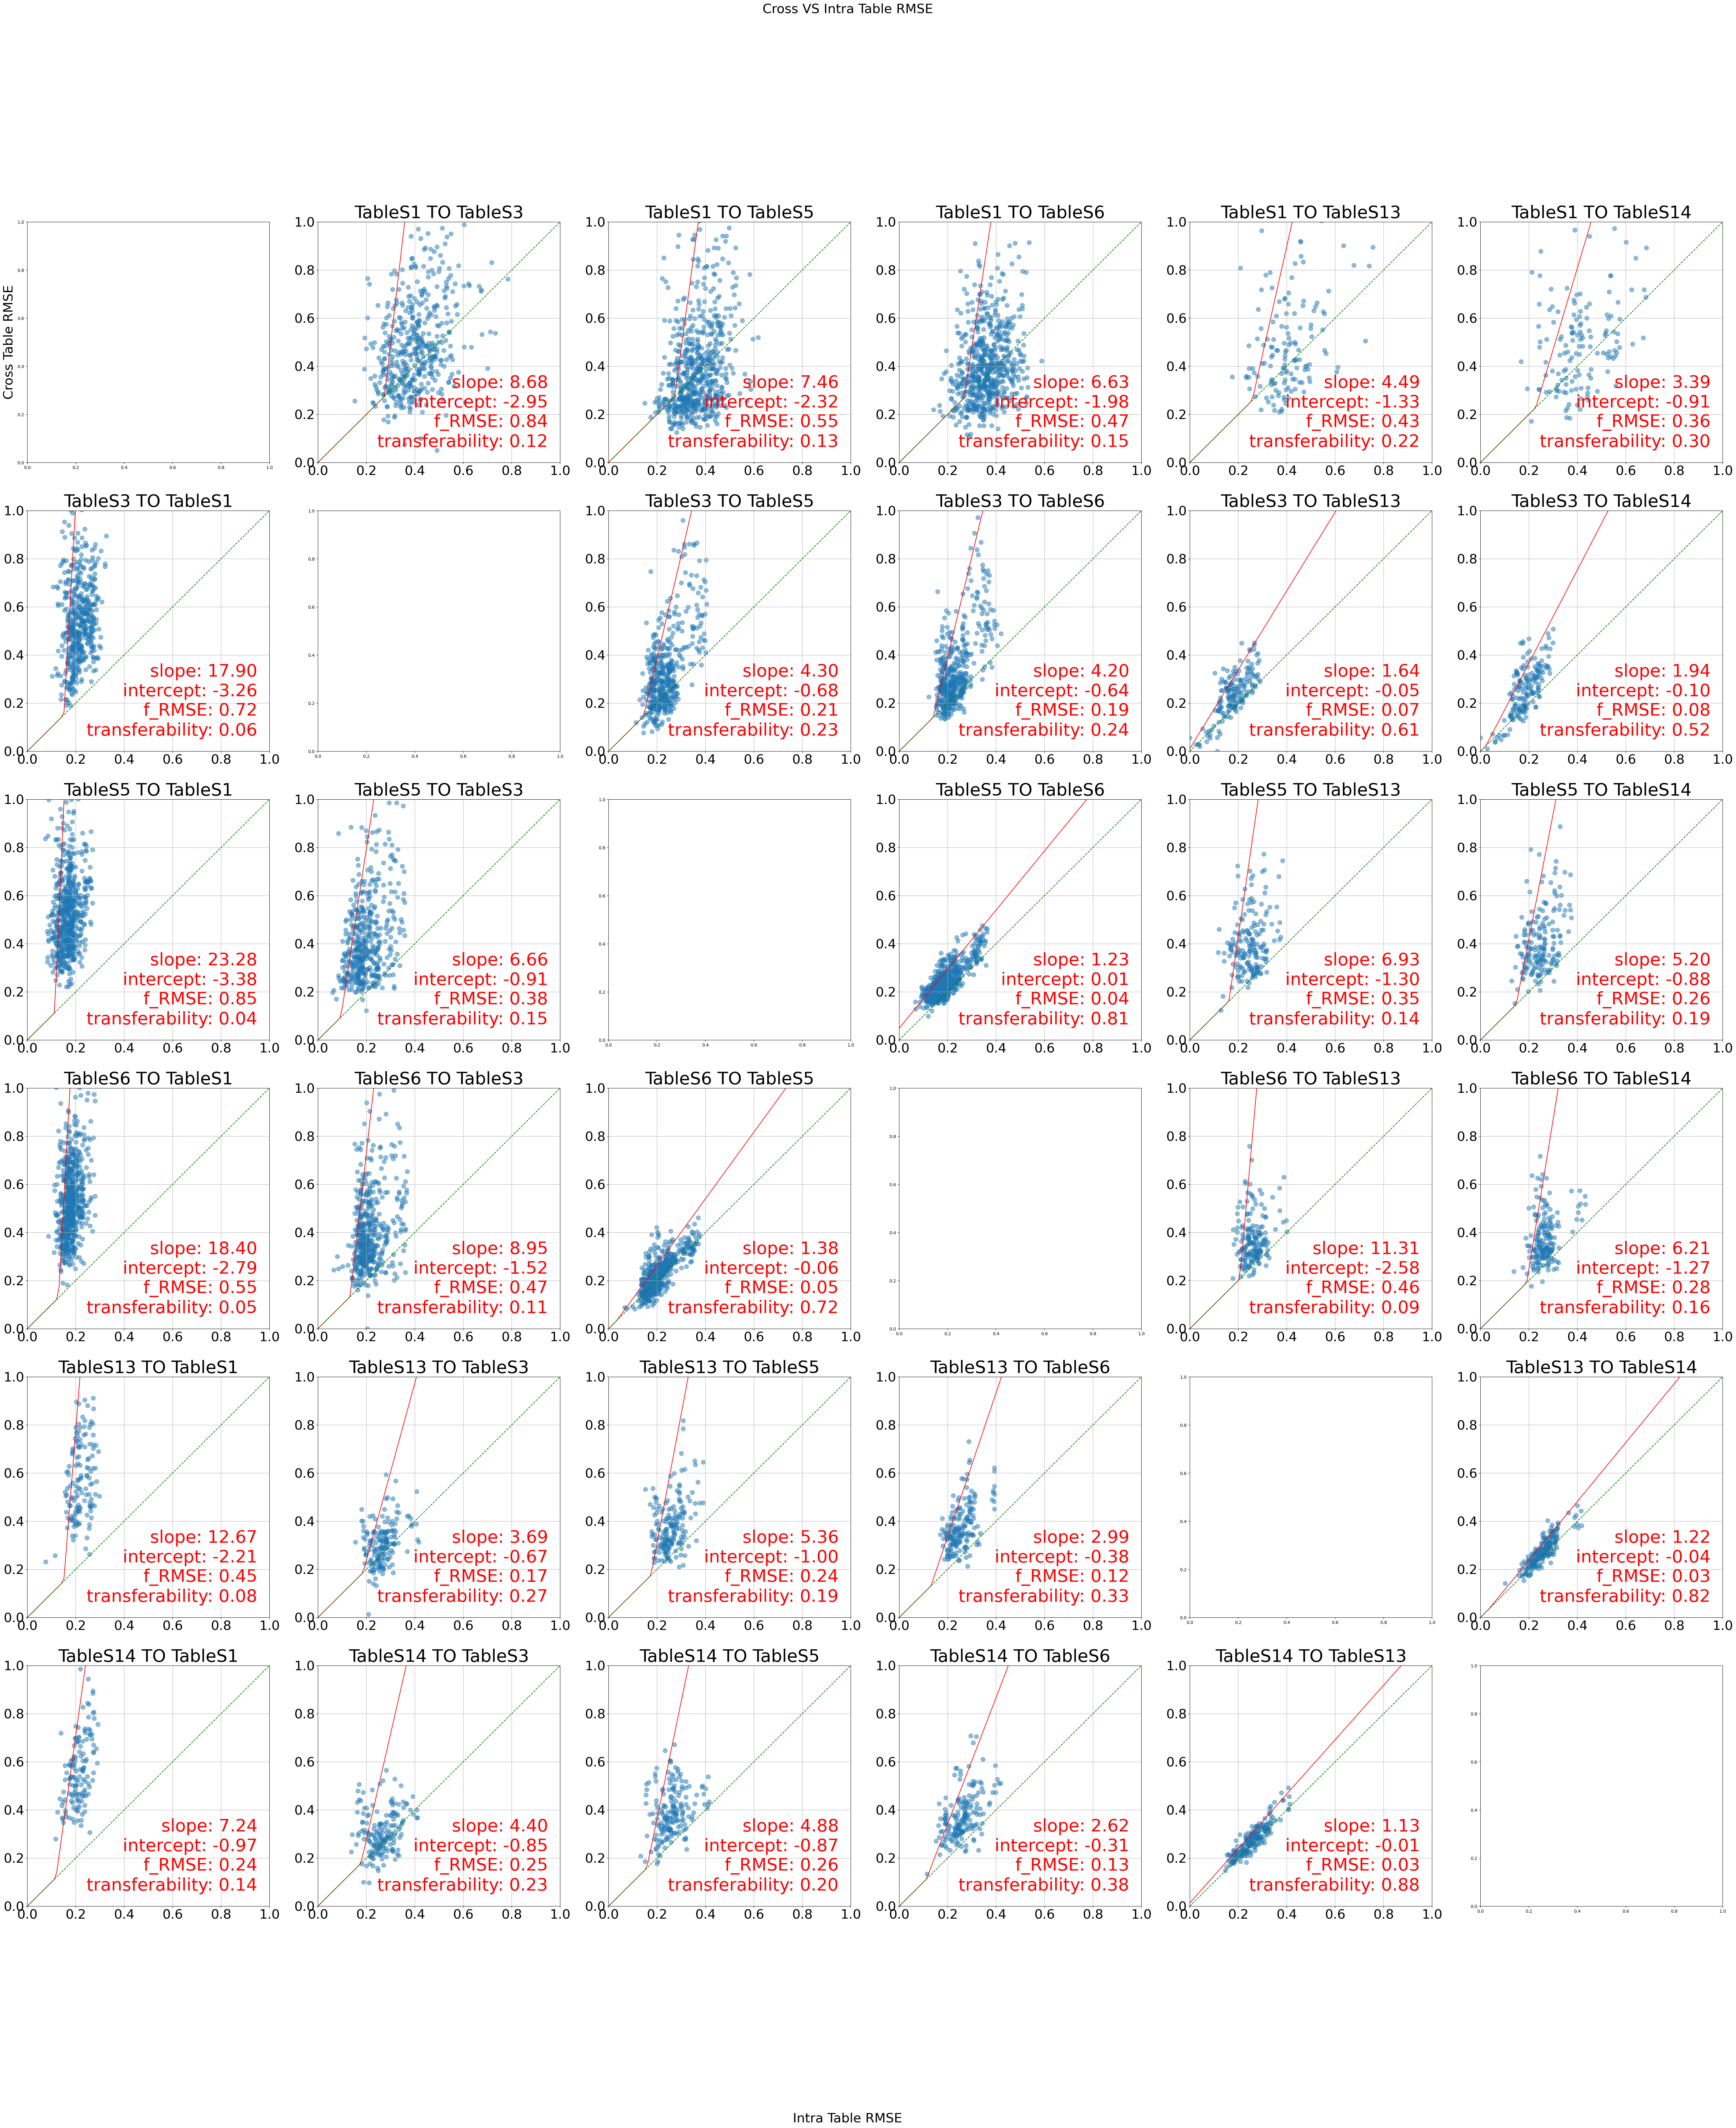

In [4]:
# Load in antisera-virus data as pd.DataFrames
fonville_2014_HI_df = pd.read_csv("data/fonville_2014.csv", index_col='sampleID')
fonville_2014_antisera_df = pd.read_csv("data/fonville_2014_antisera_table.csv", index_col='sampleID')
fonville_2014_HI_data_tables  = HI_data_tables() # Create HI_data_tables object
fonville_2014_HI_data_tables.add_HI_data(HI_df=fonville_2014_HI_df,
                               antisera_df=fonville_2014_antisera_df) # Add data from Tal's ad Rong's original paper
fonville_2014_HI_data_tables.compute_virus_dates()

np.random.seed(10)
train_trees=50
best_trees=10
n_features=5
f_sample = 0.7
fonville_2014_comparisons_obj = transferability_comparisons(HI_data_tables=fonville_2014_HI_data_tables)
model_name = f'fonville_2014_w_ODRs__traintrees{train_trees}_besttrees{best_trees}_regular_features{n_features}'
fonville_2014_comparisons_obj.load_data(path=f"models/{model_name}.pkl")
# fonville_2014_comparisons_obj.train_comparison_trees(train_trees=train_trees, best_trees=best_trees, n_features=n_features, f_sample=f_sample)
fonville_2014_comparisons_obj.compute_comparison_virus_ODR_df_dict()
fonville_2014_comparisons_obj.plot_comparisons_with_ODRs(save_to=f'figs/{model_name}.png', figsize=(70,70), s=100,  alpha=0.5)
fonville_2014_comparisons_obj.save_data(save_to=f"models/{model_name}.pkl")

# Predictions

## Fonville 2014 S14 to S13
Rare chance to actually compute RMSE for prediction on whole matrix

0.2635602818956513


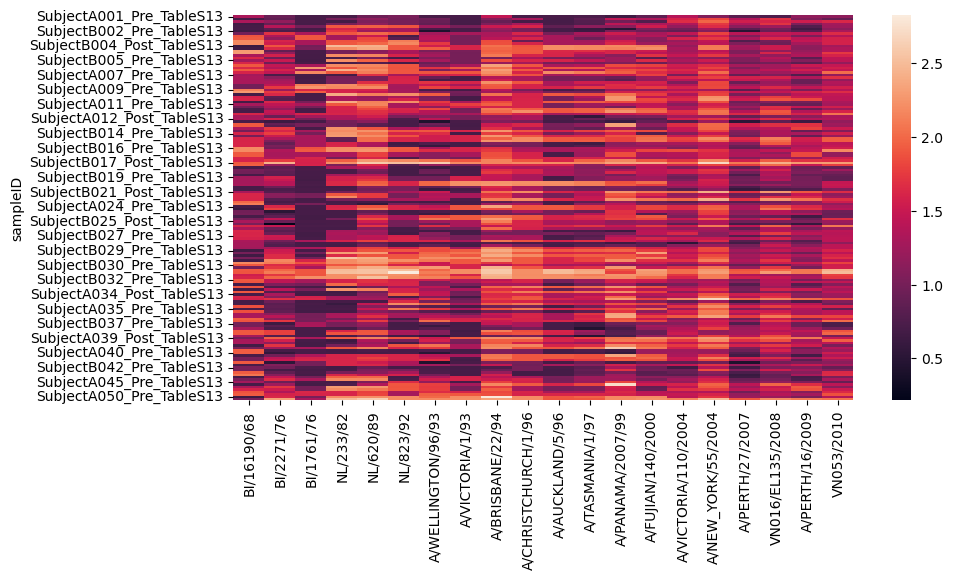

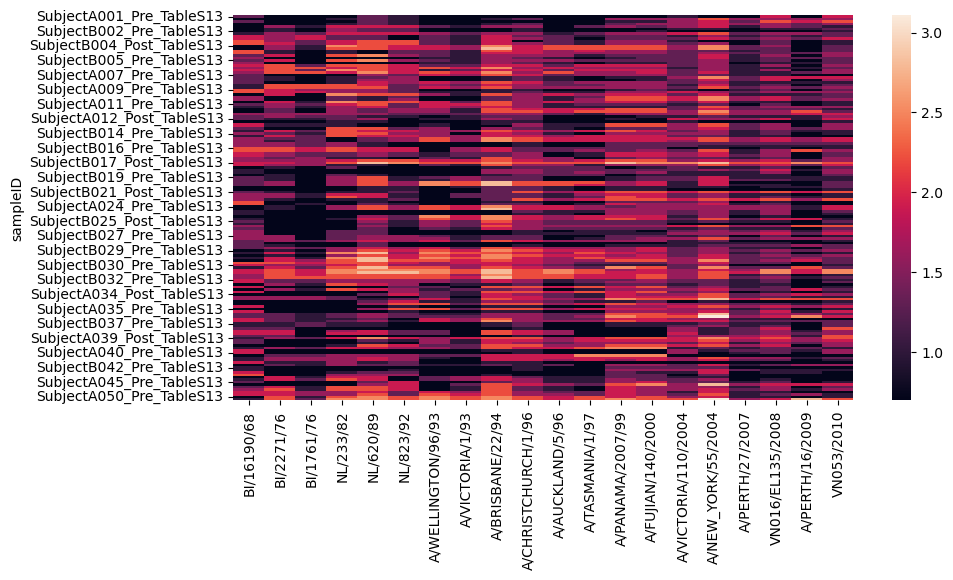

In [7]:
'''
Improves performance:
    - Increasing n_feature
    - Increasing f_sample
    - Increasing train_trees and decreasing best_trees 
Worsens performance: 
    - Increasing best_trees alone

'''
np.random.seed(10)
source_table_1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS14']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table_1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS13']).dropna(axis=1, how='all').dropna(axis=0, how='any')

m_best_trees_trainer_lists_per_target_virus_1, intersection_1 = train_cross_dataset_model(source_table_1, target_table_1, n_feature = 10, f_sample=0.8, train_trees=100, best_trees=10)
target_table_1_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_1, intersection_1, target_table_1)

RMSE_1 = np.sqrt(np.mean((target_table_1_predictions - target_table_1)**2))
print(RMSE_1)

# age_indices_1 = sorted(list(target_table_1_predictions.index), key= x: x.split('_')[0][-3:])
# age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_1_predictions.index])
# plt.figure(figsize=(10,5))
# sns.heatmap(target_table_1_predictions.iloc[age_indices_1])
# plt.show()

# age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_1.index])
# plt.figure(figsize=(10,5))
# sns.heatmap(target_table_1.iloc[age_indices_1])
# plt.show()
# sns.heatmap(source_table_1.loc[:, target_table_1_predictions.columns])

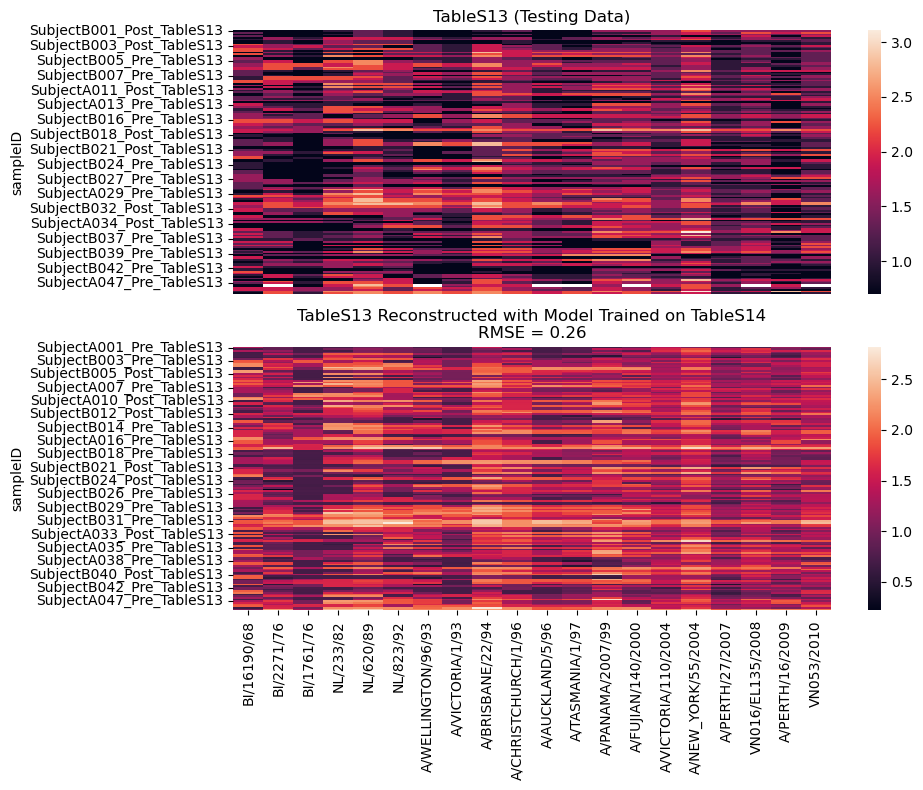

In [47]:

S14_data = all_HI_data_tables.select_HI_data_by_group(group=['TableS14']).dropna(axis=1, how="all")
age_indices_S14_data = np.argsort([i.split('_')[0][-3:] for i in S14_data.index])
S14_data = S14_data.iloc[age_indices_S14_data]

S13_data = all_HI_data_tables.select_HI_data_by_group(group=['TableS13']).dropna(axis=1, how="all")
age_indices_S13_data = np.argsort([i.split('_')[0][-3:] for i in S13_data.index])
S13_data = S13_data.iloc[age_indices_S13_data]

fig, axes = plt.subplots(2, 1, figsize=(10, 8))  # 1 row, 2 columns

# Plot the first heatmap
# sns.heatmap(S14_data, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the second heatmap
sns.heatmap(S13_data, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the third heatmap
age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_1_predictions.index])
sns.heatmap(target_table_1_predictions.iloc[age_indices_1], ax=axes[1])

RMSE = np.sqrt(np.mean((target_table_1_predictions.iloc[age_indices_1] - S13_data)**2))


# Set titles for subplots
# axes[0].set_title("TableS14 (Training Data)")
axes[0].set_title('TableS13 (Testing Data)')
axes[1].set_title(f'TableS13 Reconstructed with Model Trained on TableS14\nRMSE = {RMSE:.2f}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


# S14_data = all_HI_data_tables.select_HI_data_by_group(group=['TableS14']).dropna(axis=1, how="all")
# age_indices_S14_data = np.argsort([i.split('_')[0][-3:] for i in S14_data.index])
# S14_data = S14_data.iloc[age_indices_S14_data]

# S13_data = all_HI_data_tables.select_HI_data_by_group(group=['TableS13']).dropna(axis=1, how="all")
# age_indices_S13_data = np.argsort([i.split('_')[0][-3:] for i in S13_data.index])
# S13_data = S13_data.iloc[age_indices_S13_data]

# fig, axes = plt.subplots(3, 1, figsize=(7, 10))  # 1 row, 2 columns

# # Plot the first heatmap
# sns.heatmap(S14_data, ax=axes[0]).set(xticks=[], xlabel='')
# # Plot the second heatmap
# sns.heatmap(S13_data, ax=axes[1]).set(xticks=[], xlabel='')
# # Plot the third heatmap
# age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_1_predictions.index])
# sns.heatmap(target_table_1_predictions.iloc[age_indices_1], ax=axes[2])

# RMSE = np.sqrt(np.mean((target_table_1_predictions.iloc[age_indices_1] - S13_data)**2))


# # Set titles for subplots
# axes[0].set_title("TableS14 (Training Data)")
# axes[1].set_title('TableS13 (Testing Data)')
# axes[2].set_title(f'TableS13 Reconstructed with Model Trained on TableS14\nRMSE = {RMSE:.2f}')

# # Adjust layout to prevent overlap
# plt.tight_layout()

# # Show the plot
# plt.show()

## Fonville 2014 to 2016 Ferrets

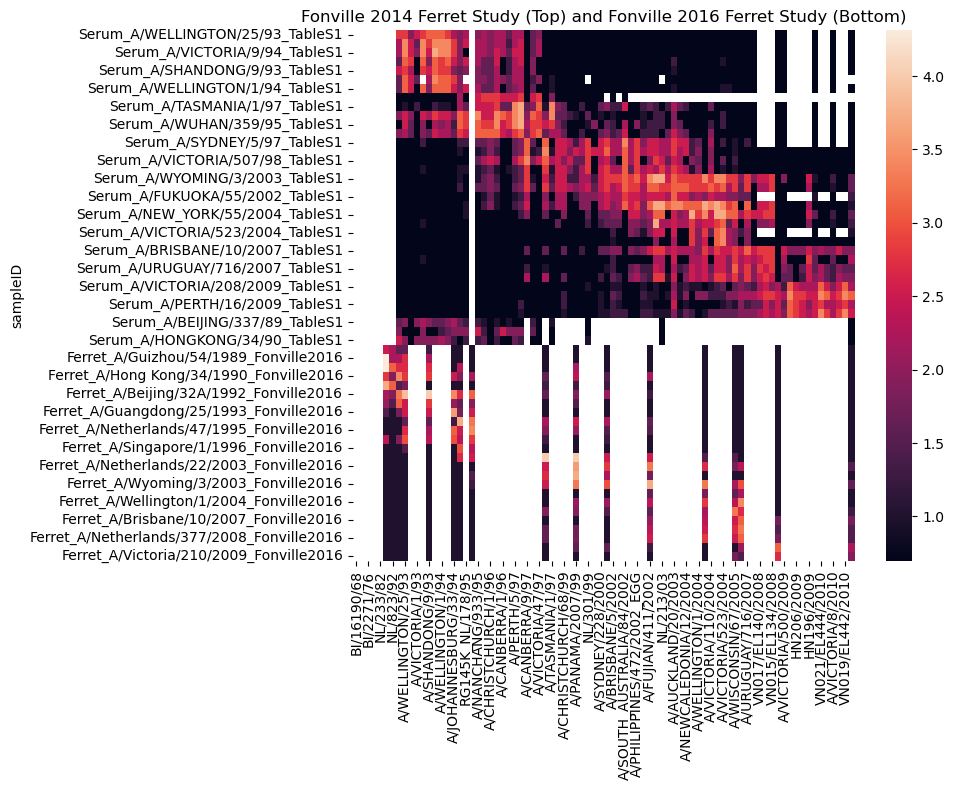

In [48]:
'''
Try filtering data before putting it in
- Depth filtering
'''
plt.figure(figsize=(10,8))
plt.title("Fonville 2014 Ferret Study (Top) and Fonville 2016 Ferret Study (Bottom)")
sns.heatmap(all_HI_data_tables.select_HI_data_by_group(group=['TableS1', 'fon_ferrets']))
# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

0.37519198656961417


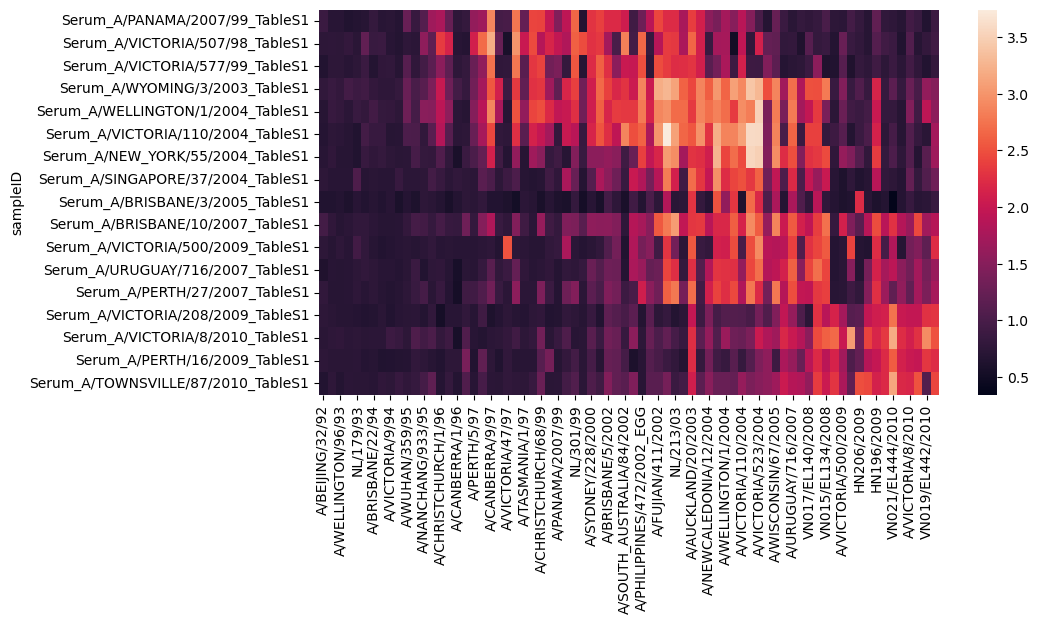

<Axes: ylabel='sampleID'>

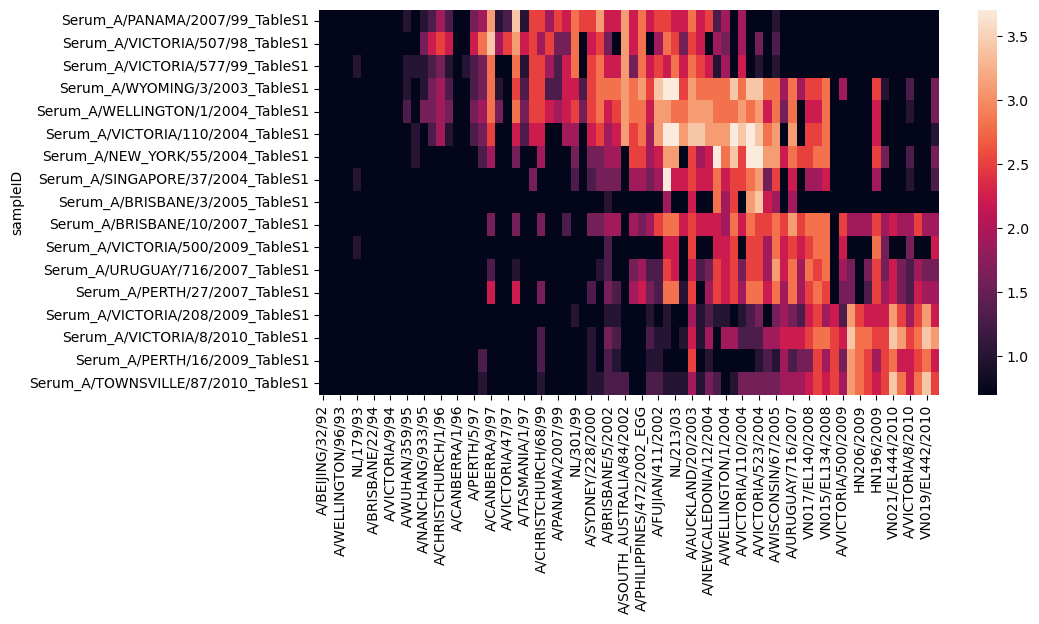

In [55]:
source_table_2 = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how='all').dropna(axis=0, how='any')
m_best_trees_trainer_lists_per_target_virus_2, intersection_2 = train_cross_dataset_model(source_table_2, source_table_2, n_feature = 8, f_sample=0.8, train_trees=200, best_trees=10)
# print(len(intersection_2))
target_table_2_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_2, intersection_2, source_table_2)

RMSE = np.sqrt(np.mean((target_table_2_predictions - source_table_2)**2))
print(RMSE)
plt.figure(figsize=(10,5))
sns.heatmap(target_table_2_predictions[source_table_2.columns])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table_2)

In [ ]:
np.random.seed(10)
source_table_1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS14']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table_1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS13']).dropna(axis=1, how='all').dropna(axis=0, how='any')

m_best_trees_trainer_lists_per_target_virus_1, intersection_1 = train_cross_dataset_model(source_table_1, target_table_1, n_feature = 10, f_sample=0.8, train_trees=100, best_trees=10)
target_table_1_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus_1, intersection_1, target_table_1)

RMSE_1 = np.sqrt(np.mean((target_table_1_predictions - target_table_1)**2))
print(RMSE_1)

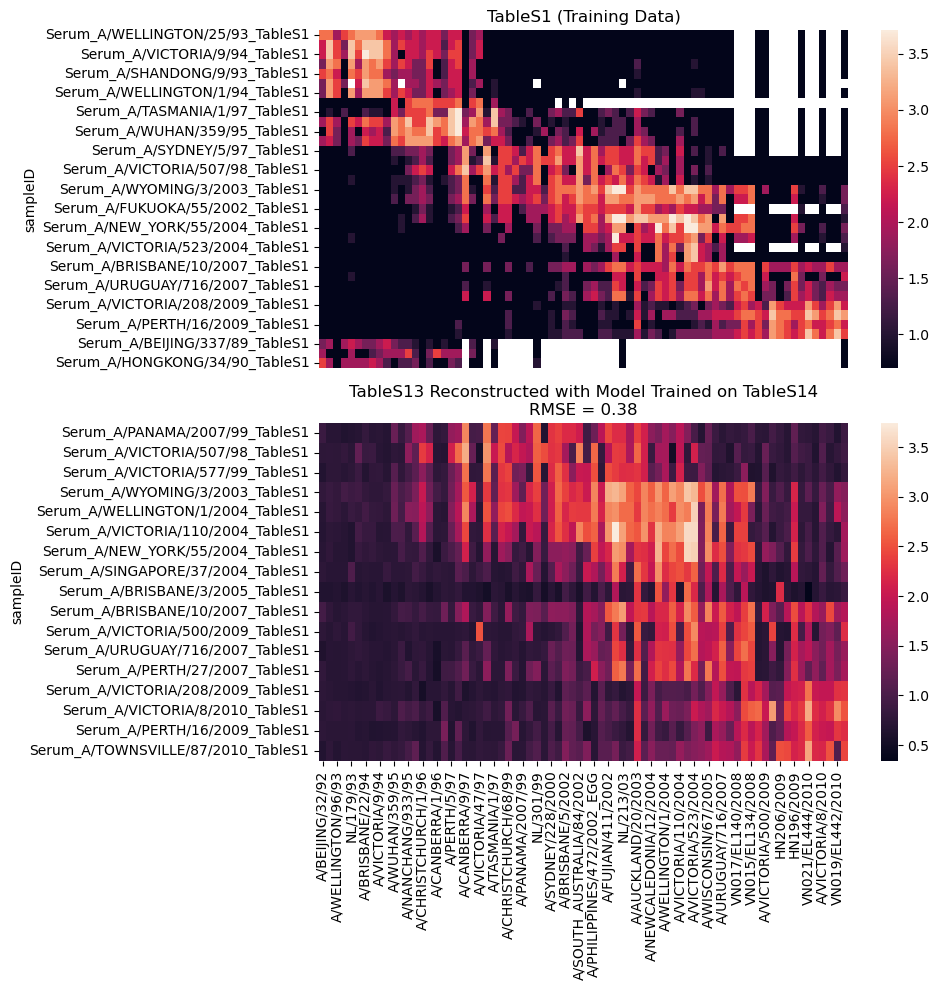

In [56]:

TableS1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how="all")

fig, axes = plt.subplots(2, 1, figsize=(10, 10))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(TableS1[source_table_2.columns], ax=axes[0]).set(xticks=[], xlabel='')
# Plot the second heatmap
# age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_2_predictions.index])
sns.heatmap(target_table_2_predictions, ax=axes[1])

RMSE = np.sqrt(np.mean((target_table_2_predictions - TableS1)**2))


# Set titles for subplots
axes[0].set_title("TableS1 (Training Data)")
axes[1].set_title(f'TableS13 Reconstructed with Model Trained on TableS14\nRMSE = {RMSE:.2f}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

14
nan


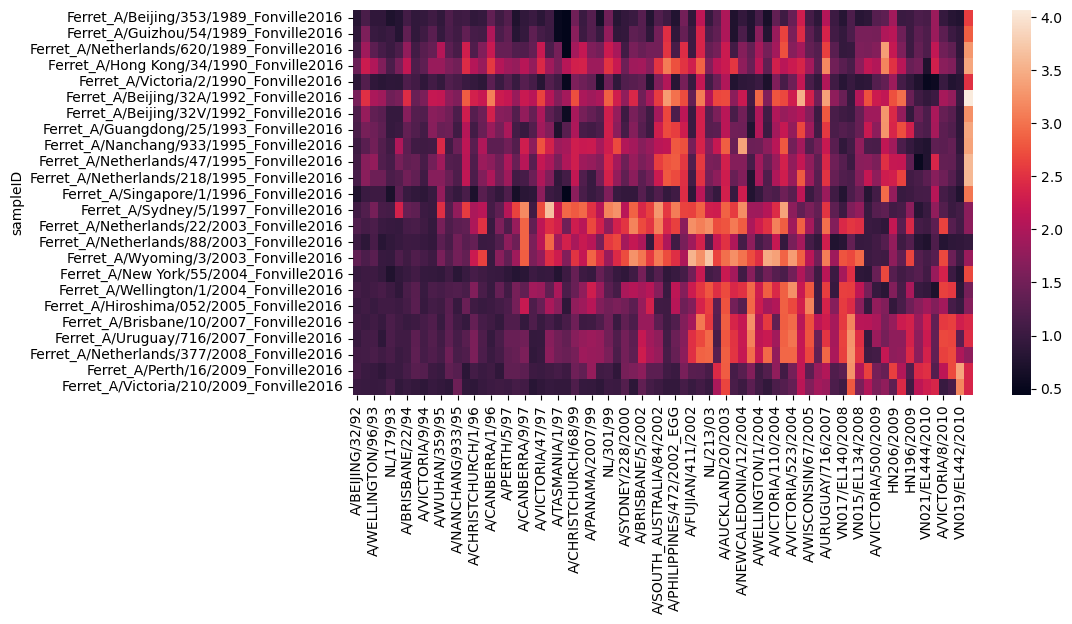

<Axes: ylabel='sampleID'>

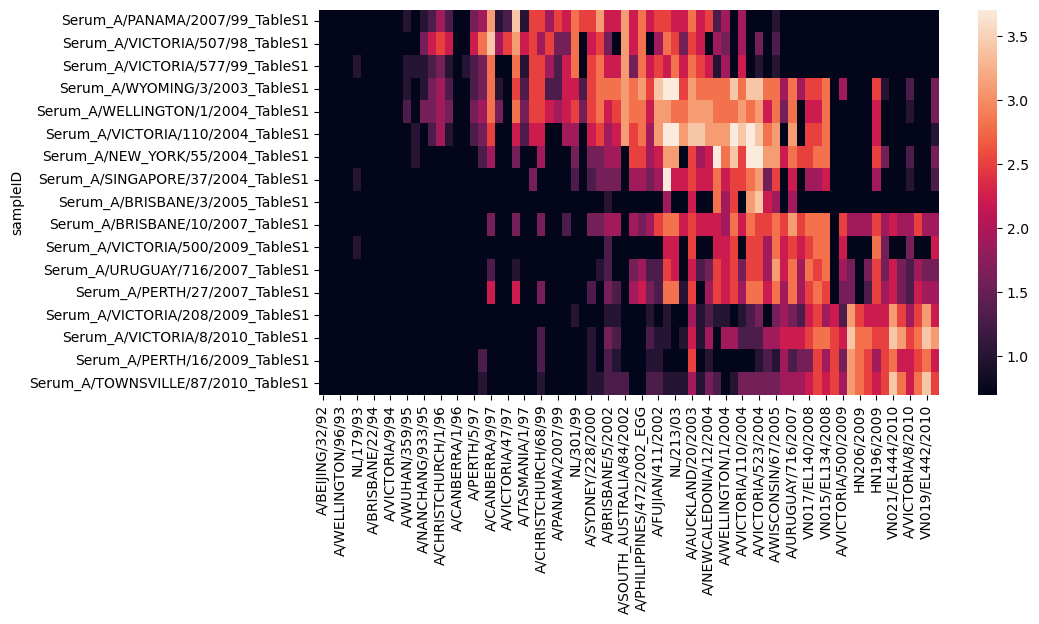

In [32]:
source_table = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table = all_HI_data_tables.select_HI_data_by_group(group=['fon_ferrets']).dropna(axis=1, how='all').dropna(axis=0, how='any')
m_best_trees_trainer_lists_per_target_virus, intersection = train_cross_dataset_model(source_table, target_table, n_feature = 8, f_sample=0.8, train_trees=200, best_trees=10)
print(len(intersection))
target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus, intersection, target_table)

RMSE = np.sqrt(np.mean((target_table_predictions[source_table.columns] - source_table)**2))
print(RMSE)
plt.figure(figsize=(10,5))
sns.heatmap(target_table_predictions[source_table.columns])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table)

In [ ]:

TableS1 = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how="all")
age_indices_TableS1 = np.argsort([i.split('_')[0][-3:] for i in TableS1.index])
TableS1 = TableS1.iloc[age_indices_TableS1]

fon_ferrets = all_HI_data_tables.select_HI_data_by_group(group=['fon_ferrets']).dropna(axis=1, how="all")
age_indices_fon_ferrets = np.argsort([i.split('_')[0][-3:] for i in fon_ferrets.index])
fon_ferrets = fon_ferrets.iloc[age_indices_fon_ferrets]

fig, axes = plt.subplots(3, 1, figsize=(7, 10))  # 1 row, 2 columns

# Plot the first heatmap
sns.heatmap(TableS1, ax=axes[0]).set(xticks=[], xlabel='')
# Plot the second heatmap
sns.heatmap(fon_ferrets, ax=axes[1]).set(xticks=[], xlabel='')
# Plot the third heatmap
age_indices_1 = np.argsort([i.split('_')[0][-3:] for i in target_table_2_predictions.index])
sns.heatmap(target_table_2_predictions.iloc[age_indices_1], ax=axes[2])

RMSE = np.sqrt(np.mean((target_table_2_predictions.iloc[age_indices_1] - fon_ferrets)**2))


# Set titles for subplots
axes[0].set_title("TableS1 (Training Data)")
axes[1].set_title('fon_ferrets (Testing Data)')
axes[2].set_title(f'TableS13 Reconstructed with Model Trained on TableS14\nRMSE = {RMSE:.2f}')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Axes: ylabel='sampleID'>

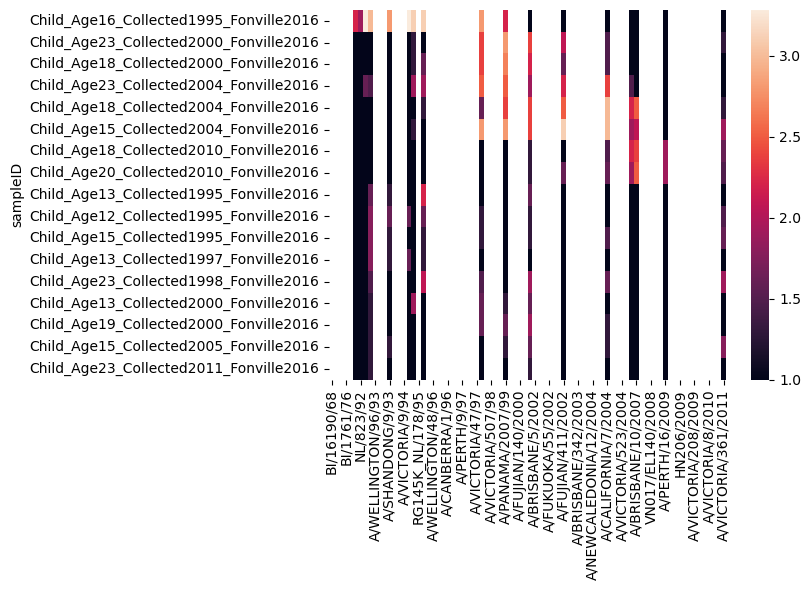

In [37]:
sns.heatmap(all_HI_data_tables.select_HI_data_by_group(group=['fon_children']))

14
nan


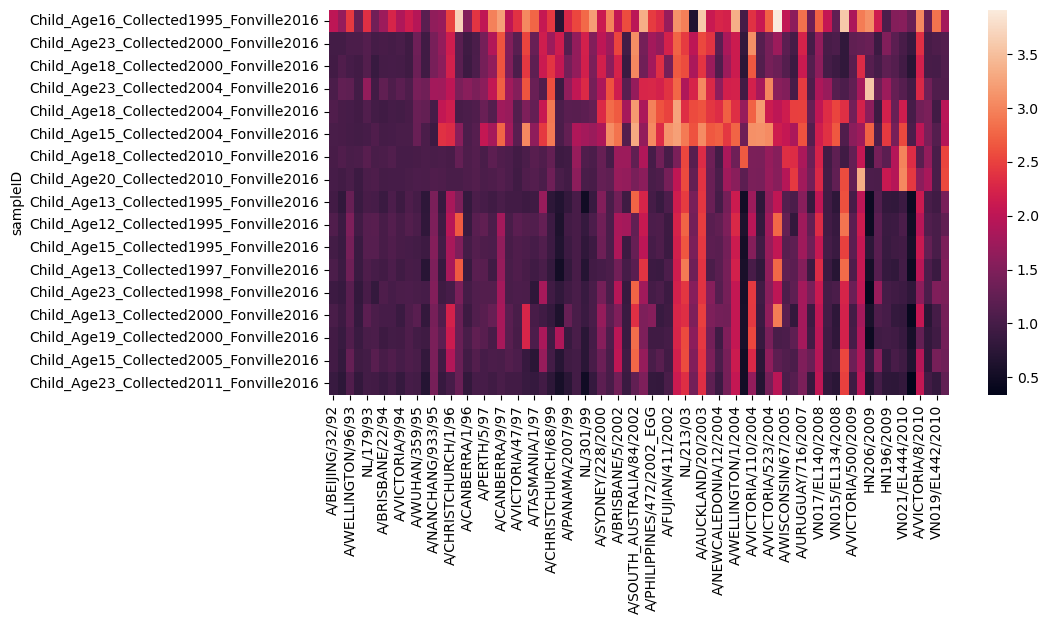

<Axes: ylabel='sampleID'>

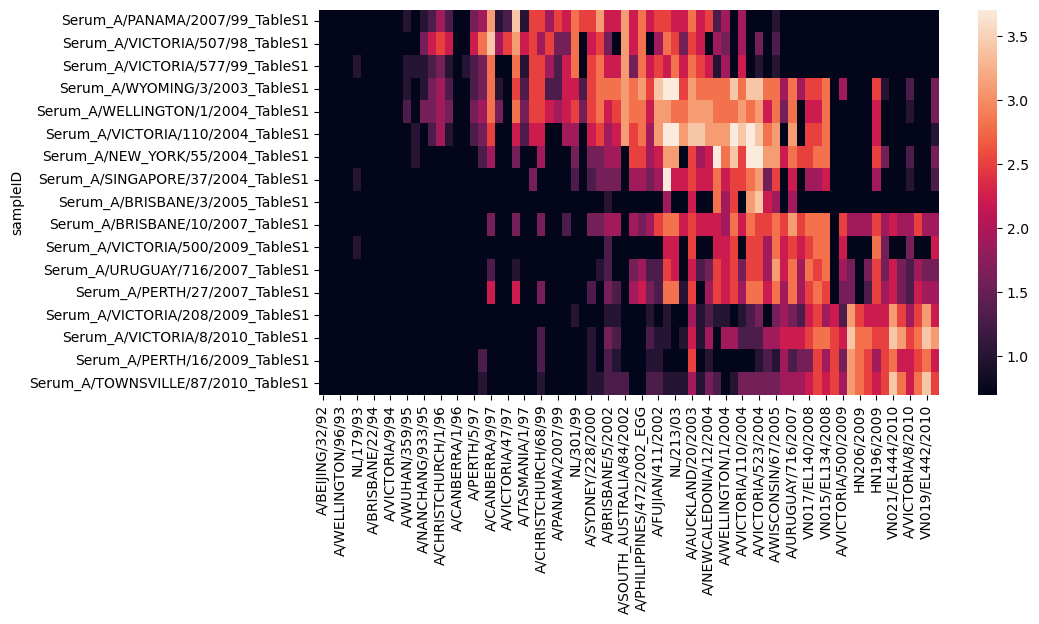

In [36]:
source_table = all_HI_data_tables.select_HI_data_by_group(group=['TableS1']).dropna(axis=1, how='all').dropna(axis=0, how='any')
target_table = all_HI_data_tables.select_HI_data_by_group(group=['fon_children']).dropna(axis=1, how='all').dropna(axis=0, how='any')
m_best_trees_trainer_lists_per_target_virus, intersection = train_cross_dataset_model(source_table, target_table, n_feature = 8, f_sample=0.8, train_trees=200, best_trees=10)
print(len(intersection))
target_table_predictions = compute_predicted_df(m_best_trees_trainer_lists_per_target_virus, intersection, target_table)

RMSE = np.sqrt(np.mean((target_table_predictions[source_table.columns] - source_table)**2))
print(RMSE)
plt.figure(figsize=(10,5))
sns.heatmap(target_table_predictions[source_table.columns])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table)

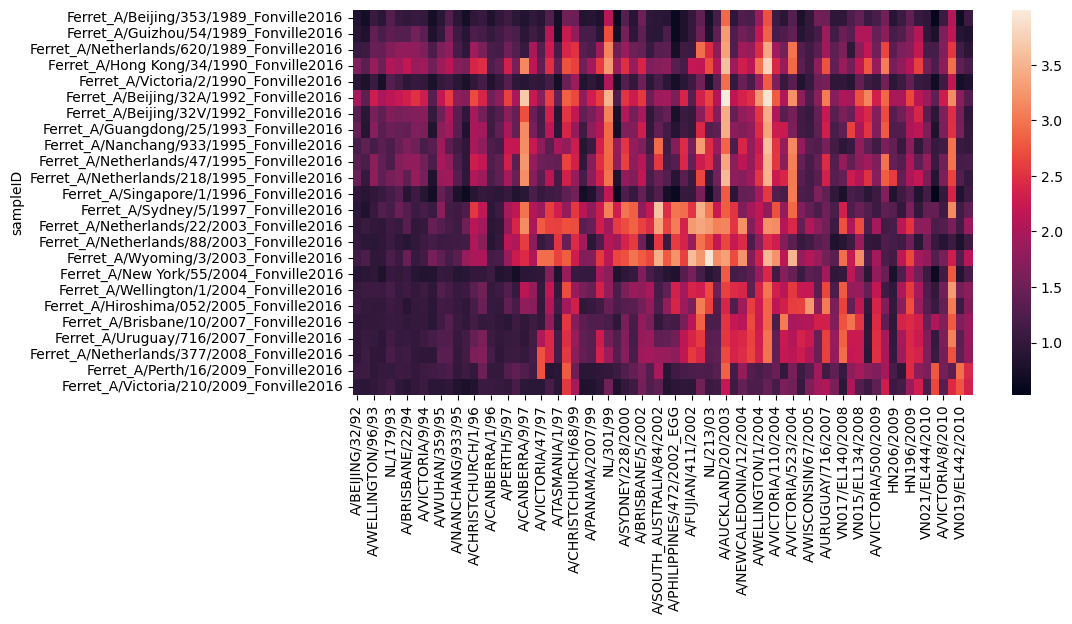

<Axes: ylabel='sampleID'>

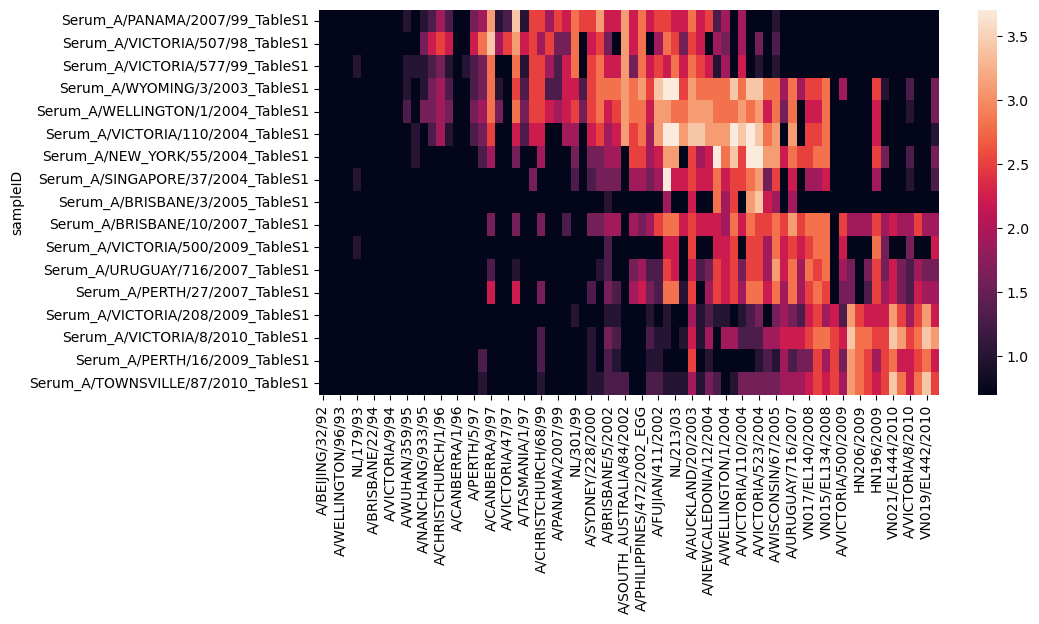

In [25]:
plt.figure(figsize=(10,5))
sns.heatmap(target_table_predictions[source_table.columns])
plt.show()
plt.figure(figsize=(10,5))
sns.heatmap(source_table)